In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import DataLoader, Dataset, RandomSampler
import math

# specify GPU
device = torch.device("cuda")

In [2]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)


# freezing the model's parameters
for param in bert.parameters():
    param.requires_grad = False

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
training_data = pd.read_csv("./Data/question_similarity/train.csv", encoding="ISO-8859-1")
training_data.head()
question_1 = training_data['question1'].tolist()
question_2 = training_data['question2'].tolist()

for i in range(len(question_1)):
    question_1[i] = str(question_1[i])
    question_2[i] = str(question_2[i])
    
labels = data['is_duplicate'].tolist()

# binary_labels = torch.tensor(binary_labels)
print(question_1[0:5])
print(question_2[0:5])

['What is the step by step guide to invest in share market in india?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?', 'How can I increase the speed of my internet connection while using a VPN?', 'Why am I mentally very lonely? How can I solve it?', 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?']
['What is the step by step guide to invest in share market?', 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?', 'How can Internet speed be increased by hacking through DNS?', 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?', 'Which fish would survive in salt water?']


In [46]:
test_data = pd.read_csv("./Data/question_similarity/test.csv", encoding="ISO-8859-1")
print(test_data.head())
test_question_1 = training_data['question1'].tolist()
test_question_2 = training_data['question2'].tolist()

for i in range(len(question_1)):
    test_question_1[i] = str(test_question_1[i])
    test_question_2[i] = str(test_question_2[i])
    
# binary_labels = torch.tensor(binary_labels)
print(test_question_1[0:5])
print(test_question_2[0:5])

   test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   
2        2  What but is the best way to send money from Ch...   
3        3                        Which food not emulsifiers?   
4        4                   How "aberystwyth" start reading?   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?  
2                      What you send money to China?  
3                                  What foods fibre?  
4                     How their can I start reading?  
['What is the step by step guide to invest in share market in india?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?', 'How can I increase the speed of my internet connection while using a VPN?', 'Why am I mentally very lonely? How can I solve it?', 'Which one dissolve in

In [41]:
len(question_1)

404290

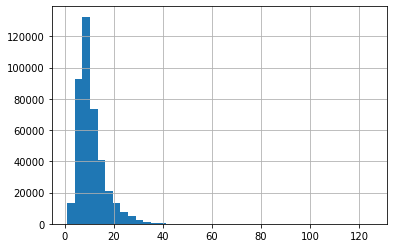

In [27]:
# get length of all the messages in the train set
seq_len = [len(question.split()) for question in question_1]

pd.Series(seq_len).hist(bins = 40)

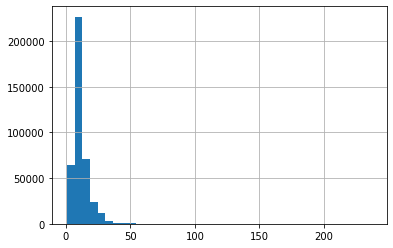

In [29]:
# get length of all the messages in the train set
seq_len = [len(question.split()) for question in question_2]

pd.Series(seq_len).hist(bins = 40)

In [34]:
max_seq_len = 50

In [47]:
tokenized_training_data = tokenizer.__call__(question_1[0:5],question_2[0:5], 
                                   max_length=max_seq_len, 
                                   truncation=True,
                                   padding=True,
                                   return_token_type_ids=False,
                                  return_tensors="pt")


tokenized_test_data = tokenizer.__call__(test_question_1[0:5],test_question_2[0:5], 
                               max_length=max_seq_len, 
                               truncation=True, 
                               padding=True,
                               return_token_type_ids=False,
                               return_tensors="pt")
# tokenized_training_data.keys()

In [48]:
print(tokenized_training_data)
print(tokenized_test_data)

{'input_ids': tensor([[  101,  2054,  2003,  1996,  3357,  2011,  3357,  5009,  2000, 15697,
          1999,  3745,  3006,  1999,  2634,  1029,   102,  2054,  2003,  1996,
          3357,  2011,  3357,  5009,  2000, 15697,  1999,  3745,  3006,  1029,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  2054,  2003,  1996,  2466,  1997, 12849, 10606, 16506,  1006,
         12849,  2232,  1011,  1045,  1011,  2053,  2953,  1007,  6323,  1029,
           102,  2054,  2052,  4148,  2065,  1996,  2796,  2231, 10312,  1996,
         12849, 10606, 16506,  1006, 12849,  2232,  1011,  1045,  1011,  2053,
          2953,  1007,  6323,  2067,  1029,   102],
        [  101,  2129,  2064,  1045,  3623,  1996,  3177,  1997,  2026,  4274,
          4434,  2096,  2478,  1037, 21210,  2078,  1029,   102,  2129,  2064,
          4274,  3177,  2022,  3445,  2011, 23707,  2083,  1040,  3619,  1029,
           10

In [49]:
class QuoraDataset(Dataset):

    def __init__(self, training_data, labels):
        # Initialize data, download, etc.
        # read with numpy or pandas
        self.training_data = training_data
        self.labels = labels
        self.n_samples = len(labels)


    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        # returns (input_id, attention_mask, label)
        return (self.training_data['input_ids'][index], self.training_data['attention_mask'][index], self.labels[index])

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [50]:
class Similarity_Model(nn.Module):
    def __init__(self, bert):
        super(Spam_Model, self).__init__()
        self.bert = bert
#         self.relu_1 = nn.ReLU()

        self.L1 = nn.Linear(768, 265)
        self.relu = nn.ReLU()
        self.L2 = nn.Linear(265, 1)
        self.sigmoid = nn.Sigmoid()
        
#         torch.nn.init.xavier_uniform(self.L1.weight)
#         self.L1.bias.data.fill_(0.01)
#         torch.nn.init.xavier_uniform(self.L2.weight)
#         self.L2.bias.data.fill_(0.01)
        

    def forward(self, sent_id, mask):
            _, cls_hs = self.bert(sent_id, attention_mask=mask)
            output = self.L1(cls_hs)
#             print(output)
            output = self.relu(output)
            output = self.L2(output)
            output = self.sigmoid(output)
            return output 

In [829]:
train_data = QuoraDataset(training_data, labels)
test_data = QuoraDataset(tokenized_test_data, test_labels)

In [830]:
train_sampler = RandomSampler(train_data)

training_data_loader = DataLoader(train_data, batch_size=64, sampler=train_sampler)
val_data_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [831]:
# train_dataiter = iter(training_data_loader)
# val_dataiter = iter(val_data_loader)
# test_dataiter = iter(test_data_loader)

In [832]:
# output = train_dataiter.next()
# # len(output[0])
# output[0][0]
# # verbose, cls_hs= bert(train_dataiter.next())

# for data in train_dataiter:
#     print(data)
    
# len(data[0])
# data

In [833]:
learning_rate = 0.001

model = Similarity_Model(bert)
# model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  


In [834]:
# Dummy Training loop
i=0
num_epochs = 5
total_samples = len(train_dataiter)
n_iterations = math.ceil(total_samples/4)
total_loss = 0
# print(total_samples, n_iterations)
for epoch in range(num_epochs):
    for i, (sent_id, mask, labels) in enumerate(training_data_loader):
        optimizer.zero_grad()

        # Forward pass
#         sent_id = sent_id.to(device)
#         mask= mask.to(device)
#         labels = labels.to(device)
        outputs = model(sent_id, mask)
#         print(outputs)
#         print(labels)
        loss = criterion(outputs[:, 0], labels.float())
        total_loss += loss
#         print(loss)
        # Backward and optimize



        loss.backward()
        optimizer.step()
#         print(i)
        if (i+1) % 50 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_samples}], Total Loss: {total_loss.item():.4f}, Loss: {loss.item():.4f}')
            total_loss = 0
        i+=1
    print(epoch)

Epoch [1/5], Step [50/975], Total Loss: 21.2042, Loss: 0.3006
Epoch [1/5], Step [100/975], Total Loss: 20.1088, Loss: 0.6612
Epoch [1/5], Step [150/975], Total Loss: 12.0120, Loss: 0.0487
Epoch [1/5], Step [200/975], Total Loss: 16.5557, Loss: 0.7074
Epoch [1/5], Step [250/975], Total Loss: 17.0691, Loss: 0.2521
Epoch [1/5], Step [300/975], Total Loss: 14.2535, Loss: 0.4050
Epoch [1/5], Step [350/975], Total Loss: 12.3993, Loss: 0.0187
Epoch [1/5], Step [400/975], Total Loss: 13.3210, Loss: 0.0114
Epoch [1/5], Step [450/975], Total Loss: 12.0070, Loss: 0.1329
Epoch [1/5], Step [500/975], Total Loss: 12.2986, Loss: 1.0939
Epoch [1/5], Step [550/975], Total Loss: 8.0921, Loss: 0.0010
Epoch [1/5], Step [600/975], Total Loss: 14.8193, Loss: 0.3112
Epoch [1/5], Step [650/975], Total Loss: 8.8135, Loss: 0.0268
Epoch [1/5], Step [700/975], Total Loss: 9.5519, Loss: 0.0144
Epoch [1/5], Step [750/975], Total Loss: 12.3649, Loss: 0.0024
Epoch [1/5], Step [800/975], Total Loss: 8.2679, Loss: 0.44

KeyboardInterrupt: 

In [845]:
correct_guesses = 0
false_guesses = 0
for i, (sent_id, mask, label) in enumerate(test_data_loader):
    with torch.no_grad():
        preds = model(sent_id, mask)
        for i in range(len(preds)):
            print(int(round(float(preds[i][0]))))
            if int(round(float(preds[i][0]))) == label[i]:
                correct_guesses += 1
            else:
                false_guesses += 1
#             preds = preds.detach().cpu().numpy()


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0


In [847]:
print(correct_guesses)

765


In [331]:
# example

from transformers import AutoTokenizer, TFAutoModel

# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
ex_inputs = tokenizer(["Hello world!", "hello world 2"], return_tensors="pt")


# # The ** operator allows us to take a dictionary of key-value pairs and unpack it into keyword arguments in a ***function call***
ex_outputs = bert(**ex_inputs)

ex_outputs 

# print(ex_outputs.last_hidden_state.shape)
# print(ex_outputs[0].shape)


# print(ex_outputs.pooler_output.shape)
print(ex_outputs[1].shape)

# false usage (used in function calls)
# print(**ex_inputs.items())


torch.Size([2, 768])


In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

sentence_a = "this is a sentence"
sentence_b = "this is another sentence"

encoding = tokenizer(sentence_a, sentence_b, padding=True, truncation=True, 
                               max_length=30,  
                               return_token_type_ids=False,
                               return_tensors="pt")

In [13]:
encoding

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 6251,  102, 2023, 2003, 2178, 6251,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}